In [30]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib_venn import venn3, venn2
import seaborn as sns

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
workingDirectory = '/home/h1bennet/strains_rna/results/A10_Manuscript_Figures_AllLiverCells//'
leptinDirectory = '/home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/'
controlDirectory = '/home/h1bennet/strains/data/RNA/control_kupffer/'
dataDirectory = '/home/h1bennet/strains_rna/results/K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped//'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

if not os.path.isdir('./leptin_treatment'):
    os.mkdir('./leptin_treatment')


In [32]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

# Make hub to look at individual files

# Import differential gene files for examination and plotting

Make folder for figures

In [33]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

Plot our own version of scatter

In [34]:
comps = ['aj_kupffer_control.vs.aj_kupffer_leptin_6hours.scatter.homer.txt']

ids = [['AJ.*Kupffer', 'aj.*leptin_6h']]

labels = [['AJ control', 'AJ Leptin 6hours']]

colors = [['#bdbdbd', '#a50f15']]

# set plotting thresholds
pthresh = 0.05
fontsize=10
labelsize=6
lfcthresh = (np.log2(1.5),2)
dotsize = 0.5
ax_max = 16
n_yticks = 5
ytickstep = 3
color = '#636363'
filename='aj_leptin_treatment_combined_scatter.pdf'

aj_kupffer_control.vs.aj_kupffer_leptin_6hours.scatter.homer.txt
ge all transcripts (24940, 18)
Diff Gene selected transcripts (9289, 14)
ge selected transcripts (9289, 18)
8018 peaks
39 genes up in group 1
27 genes up in group 2


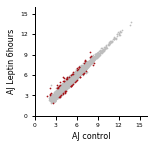

In [35]:
fig, ax = plt.subplots(1,1,
                        figsize=(2,2),
                        sharex=True,
                        sharey=True)
plt.subplots_adjust(wspace=0.2,
                    hspace=0.2)

# set count for labeling axes
count=0

for comp, grep, labs, color in zip(comps, ids, labels, colors):
    print(comp)
    de, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        '../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/'+comp,
        '../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/expression/HOMER.rawTPM.txt',
        gene_name_index=True)
    
    # extract columns
    g0 = tpm_mat.columns.str.contains(grep[0])
    g1 = tpm_mat.columns.str.contains(grep[1])
    col = g0 | g1
    
    de['logtpm'] = np.log2(tpm_mat.loc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.padj + 10**(-50))
    de['g0_mean'] = np.log2(tpm_mat.loc[:, g0].mean(1)+1)
    de['g1_mean'] = np.log2(tpm_mat.loc[:, g1].mean(1)+1)
       
    # plot group by group scatter:
    de_nonsig = de.reindex(de.index[de.padj >= pthresh])
    de_sig_fc1 = de.reindex(de.index[(de.padj < pthresh) & (np.abs(de.log2FoldChange) >= lfcthresh[0])])
    
    # check number of peaks in each group
    print(de_nonsig.shape[0], 'peaks')
    print((de_sig_fc1.log2FoldChange > lfcthresh[0]).sum(), 'genes up in group 1')
    print((de_sig_fc1.log2FoldChange < -lfcthresh[0]).sum(), 'genes up in group 2')
    
    for df, c in zip([de_nonsig, de_sig_fc1],
                     color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize,
            #rasterized=True
        )
     
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

    ax.set_xlabel(labs[0], fontsize=labelsize+2)
    ax.set_ylabel(labs[1], fontsize=labelsize+2)
    
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    
    count = count + 1
plt.savefig('./leptin_treatment/'+filename, bbox_inches='tight')

# Metascape

In [7]:
meta = pd.read_excel('../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/gene_lists/aj_kupffer_leptin_6hours_up_kupffer_genes_fc_0.58_pval_0.05_/metascape_result.xlsx',
                     sheet_name=1)

In [8]:
['GO:1903131', 'ko04152', 'GO:0031331']
['Mononuclear Cell\nDifferentiation',
                      'AMPK\nSignaling',
                      'Reg. of Cellular\nCatabolism']

['Mononuclear Cell\nDifferentiation',
 'AMPK\nSignaling',
 'Reg. of Cellular\nCatabolism']

In [9]:
leptin_act_terms = ['R-MMU-1799339', 'GO:0006119', 'GO:0032642']
leptin_act_strings = ['Antigen\nPresentation',
                    'Oxidative\nPhosphorylation',
                    'Chemokine\nProduction']
leptin_rep_terms = ['GO:1903131', 'ko04152', 'GO:0031331']
leptin_rep_strings = ['Mononuclear Cell\nDifferentiation',
                      'AMPK\nSignaling',
                      'Reg. of Cellular\nCatabolism']

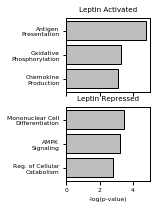

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(1.5,3),
                               sharex=True)
plt.subplots_adjust(wspace=0.7)

meta = pd.read_excel(
    '../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/gene_lists/aj_kupffer_leptin_6hours_up_kupffer_genes_fc_0.58_pval_0.05_/metascape_result.xlsx',
    sheet_name=1)
meta_filt = meta.loc[meta['Term'].str.contains('|'.join(leptin_act_terms))]
meta_filt = meta_filt.sort_values('LogP', ascending=True)
meta_filt = meta_filt.reindex(meta_filt.Term.drop_duplicates().index)

y_ind = np.arange(len(leptin_act_terms))
enrichment = -meta_filt['LogP']
ax1.barh(y_ind,
         enrichment,
         align='center',
         linewidth=1,
         edgecolor='k',
         color='#bdbdbd')
ax1.set_yticks(y_ind)
ax1.set_yticklabels(leptin_act_strings)
ax1.invert_yaxis()
ax1.set_title('Leptin Activated')
# ax1.set_xlabel('-log(p-value)')


meta = pd.read_excel(
    '../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/gene_lists/aj_kupffer_control_up_kupffer_genes_fc_0.58_pval_0.05_//metascape_result.xlsx',
    sheet_name=1)
meta_filt = meta.loc[meta['Term'].str.contains('|'.join(leptin_rep_terms))]
meta_filt = meta_filt.sort_values('LogP', ascending=True)
meta_filt = meta_filt.reindex(meta_filt.Term.drop_duplicates().index)

y_ind = np.arange(len(leptin_rep_terms))
enrichment = -meta_filt['LogP']
ax2.barh(y_ind,
         enrichment,
         align='center',
         linewidth=1,
         edgecolor='k',
         color='#bdbdbd')
ax2.set_yticks(y_ind)
ax2.set_yticklabels(leptin_rep_strings)
ax2.invert_yaxis()
ax2.set_title('Leptin Repressed')
ax2.set_xlabel('-log(p-value)')

plt.savefig('../A10_Manuscript_Figures_AllLiverCells/leptin_treatment_GO_long.pdf',
            bbox_inches='tight')

## Write differential genes to list for metascape

In [36]:
glob.glob('../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/*')

['../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/overall.heatmap.txt',
 '../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/balbc_kupffer_control.vs.balbc_kupffer_leptin_6hours.scatter.homer.txt',
 '../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/balbc_kupffer_leptin_6hours.vs.balbc_kupffer_control.scatter.homer.txt',
 '../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/balbc_kupffer_leptin_6hours.vs.balbc_kupffer_control.scatter.pdf',
 '../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/balbc_kupffer_control.vs.balbc_kupffer_leptin_6hours.scatter.txt',
 '../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/balbc_kupffer_leptin_6hours.vs.balbc_kupffer_control.scatter.txt',
 '../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/aj_kupffer_control.vs.aj_kupffer_leptin_6hours.scatter.homer.txt',
 '../K06b_Strains_Leptin6htoControl_Kupffer_OutliersD

In [48]:
i.split('.')

['',
 '',
 '/K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/aj_kupffer_leptin_6hours',
 'vs',
 'aj_kupffer_control',
 'scatter',
 'homer',
 'txt']

In [61]:
gene_list_dict = {}
pval=0.05
log2fc=np.log2(1.5)
for i in np.sort(glob.glob('../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/c57*c57*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[4]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))

for i in np.sort(glob.glob('../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/balb*balb*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[4]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))
    
for i in np.sort(glob.glob('../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/aj*aj*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[4]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))

../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/balbc_kupffer_control.vs.balbc_kupffer_leptin_6hours.scatter.homer.txt
ge all transcripts (24940, 18)
Diff Gene selected transcripts (9168, 14)
ge selected transcripts (9168, 18)
../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/balbc_kupffer_leptin_6hours.vs.balbc_kupffer_control.scatter.homer.txt
ge all transcripts (24940, 18)
Diff Gene selected transcripts (9168, 14)
ge selected transcripts (9168, 18)
../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/aj_kupffer_control.vs.aj_kupffer_leptin_6hours.scatter.homer.txt
ge all transcripts (24940, 18)
Diff Gene selected transcripts (9289, 14)
ge selected transcripts (9289, 18)
../K06b_Strains_Leptin6htoControl_Kupffer_OutliersDropped/differential/aj_kupffer_leptin_6hours.vs.aj_kupffer_control.scatter.homer.txt
ge all transcripts (24940, 18)
Diff Gene selected transcripts (9289, 14)
ge selected transcripts (9289, 18)


In [62]:
# for key in gene_list_dict.keys():
#     print(key)
#     print(len(gene_list_dict[key]), 'genes')
#     with open('./gene_lists/'+key+'_kupffer_genes_fc_%.2f_pval_%.2f_.txt' % (log2fc, pval), 'w') as f:
#         f.write('Gene\n')
#         for i in gene_list_dict[key]:
#             f.write(i+'\n')
#         f.close()

# look at  overlap with strain specific gene sets

Read in strain specific gene sets

In [63]:
strain_spec_kc_genes = {}
for gene_list_path in glob.glob('/home/h1bennet/strains_rna/results/K00_Strains_Control_Kupffer_RNA/gene_lists/*txt'):
    gene_list = []
    gene_list_name = gene_list_path.split('/')[-1].split('_kupffer')[0]
    with open(gene_list_path, 'r') as f:
        strain_spec_kc_genes[gene_list_name] = [i.strip() for i in f.readlines()][1:]
    

There is mild overlap between these gene sets

In [64]:
gene_list_dict.keys()

dict_keys(['balbc_kupffer_leptin_6hours_up', 'balbc_kupffer_control_up', 'aj_kupffer_leptin_6hours_up', 'aj_kupffer_control_up'])

In [65]:
for key in strain_spec_kc_genes.keys():
    print(key)
    print(len(set(gene_list_dict['aj_kupffer_leptin_6hours_up']).intersection(strain_spec_kc_genes[key])))
    print(set(gene_list_dict['aj_kupffer_leptin_6hours_up']).intersection(strain_spec_kc_genes[key]))

aj_intersection
0
set()
balb_intersection
3
{'Lgals1', 'Ifi27l2a', 'Trem2'}
c57_intersection
0
set()
balb_union
6
{'Lgals1', 'Ifi27l2a', 'Trem2', 'Per1', 'Anxa2', 'Rcan1'}
aj_union
3
{'Marco', 'Lgals1', 'Ikbke'}
c57_union
6
{'Ikbke', 'Per1', 'Marco', 'Rgs1', 'D17H6S56E-5', 'Mki67'}


In [66]:
print(len(strain_spec_kc_genes['balb_union']))

230


In [67]:
print(len(set(gene_list_dict['aj_kupffer_control_up'])))

27


In [68]:
for key in strain_spec_kc_genes.keys():
    print(key)
    print(len(set(gene_list_dict['aj_kupffer_control_up']).intersection(strain_spec_kc_genes[key])))
    print(set(gene_list_dict['aj_kupffer_control_up']).intersection(strain_spec_kc_genes[key]))

aj_intersection
0
set()
balb_intersection
0
set()
c57_intersection
0
set()
balb_union
2
{'Lepr', 'Rnf144b'}
aj_union
4
{'Fosb', 'Mturn', 'Rnf144b', 'Vipr1'}
c57_union
4
{'Fosb', 'Ncoa1', 'Lepr', 'Vipr1'}


In [69]:
len(strain_spec_kc_genes['aj_union'])

227

In [70]:
print(len(set(gene_list_dict['aj_kupffer_control_up'])))

27


In [71]:
stats.fisher_exact([[9289-227-27-4, 27-4], [227-4, 4]], alternative='greater')

(7.043088321310197, 0.0039301583384493705)

In [59]:
import scipy.stats as stats

## test enrichment of balb union genes in leptin induced set

In [72]:
de.shape

(9289, 19)

In [77]:
print(de.shape[0])
print(len(set(strain_spec_kc_genes['balb_union'])))
print(len(set(gene_list_dict['aj_kupffer_leptin_6hours_up'])))
print(len(set(gene_list_dict['aj_kupffer_leptin_6hours_up']).intersection(strain_spec_kc_genes['balb_union'])))

9289
230
37
6


Contingency table explained:  

genes in dataset: 9289  
genes 2 fold up in balb union: 230  
genes 1.5 fold induced by leptin in aj: 37  
overlap between two gene sets: 6.  

|  |Not in A              | in A |
|:---:|:----------------------:|:-----:
Not in B|9289 - 224 - 31 - 6 | 37-6
In B|230-6                | 6

In [60]:
stats.fisher_exact([[9289-224-31, 37-6], [230-6, 6]], alternative='greater')

(7.8058755760368665, 0.0002628836657345142)

In [78]:
print(de.shape[0])
print(len(set(strain_spec_kc_genes['balb_union'])))
print(len(set(gene_list_dict['aj_kupffer_control_up'])))
print(len(set(gene_list_dict['aj_kupffer_control_up']).intersection(strain_spec_kc_genes['balb_union'])))

9289
230
27
2


In [79]:
stats.fisher_exact([[9289-224-27-2, 27-2], [230-2, 2]], alternative='greater')

(3.170526315789474, 0.14325594424333038)

# Lets look at overlap between BALB and AJ differential genes in particular

In [81]:
pval = 0.05
log2fc = np.log2(1.5)
for i in np.sort(glob.glob('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_control.vs.balbcj_control.scatter.txt')):
    print(i)
    # read in gene expression data
    df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)
    
    # select differential genes
    # df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('/')[-1]] = list(sig_genes)

/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_control.vs.balbcj_control.scatter.txt


In [82]:
df.shape

(7619, 7)

In [83]:
import scipy.stats as stats

In [84]:
key='aj_control.vs.balbcj_control.scatter.txt'
print(key)
print(len(set(gene_list_dict['aj_kupffer_leptin_6hours_up']).intersection(gene_list_dict[key])))
print(set(gene_list_dict['aj_kupffer_leptin_6hours_up']).intersection(gene_list_dict[key]))

aj_control.vs.balbcj_control.scatter.txt
10
{'Hspa1a', 'Lgals1', 'Ifi27l2a', 'Trem2', 'Rpl37rt', 'Sem1', 'Per1', 'Anxa3', 'Fabp7', 'Rcan1'}


In [85]:
key='aj_control.vs.balbcj_control.scatter.txt'
print(key)
print(len(set(gene_list_dict['aj_kupffer_control_up']).intersection(gene_list_dict[key])))
print(set(gene_list_dict['aj_kupffer_control_up']).intersection(gene_list_dict[key]))

aj_control.vs.balbcj_control.scatter.txt
1
{'Lepr'}


In [86]:
print(len(gene_list_dict[key]))

239


## test enrichment of balb up vs aj genes in leptin induced set

Contingency table explained:
genes in dataset: 7619
genes 2 fold up in balb vs aj: 239
genes 1.5 fold induced by leptin in aj: 37
overlap between two gene sets: 10.

|  |Not in A              | in A |
|:---:|:----------------------:|:-----:
Not in B|7353 - 229 - 27 - 10 | 37-10
In B|229-10                | 10

In [87]:
stats.fisher_exact([[7353-229-27-10, 37-10], [229-10, 10]], alternative='greater')

(11.985455775410113, 1.1897668481120654e-07)

In [88]:
stats.fisher_exact([[7353-229-27-1, 37-1], [229-1, 1]], alternative='greater')

(0.8645224171539961, 0.6903356597654796)